# Diffusion Model Lab: Building Stable Diffusion from Scratch

(adapted from Harvard seminars)

## Introduction
Welcome to the Diffusion Models Laboratory! In this lab, you will implement essential components
of a Stable Diffusion-like model and have a working text-to-image generation system by the end.

## Learning Objectives
By completing this lab, you will:
1. Understand the theory behind diffusion models
2. Implement key components of a diffusion-based generative model
3. Learn how to train and sample from diffusion models
4. Experience how attention mechanisms enable text-conditioning
5. Explore the efficiency benefits of latent diffusion models

## Lab Overview
This lab will guide you through building a complete diffusion-based generative model with the following components:
1) Forward and reverse diffusion processes for generating new content
2) Neural networks with appropriate inductive biases for images (U-Net architecture)
3) Cross-attention mechanisms to bridge text and visual features
4) Latent spaces for efficient image representation via autoencoders

We'll use the MNIST dataset (28x28 pixel handwritten digits) as our training data to make the
process reasonably fast. By the end, your model will convert a text prompt like "7" into
an image of the handwritten digit 7.

## Lab Structure
This lab is divided into several tasks, each focusing on a different component of diffusion models:
- Task 1: Implement forward and reverse diffusion processes
- Task 2: Implement the U-Net architecture for diffusion
- Task 3: Develop loss functions and sampling mechanisms
- Task 4: Build attention mechanisms for conditioning
- Task 5: Create a latent diffusion model with an autoencoder

For each task, you'll find:
- Theoretical background explaining key concepts
- Starter code with TODOs for you to complete
- Testing functions to verify your implementations
- Visualization helpers to understand what's happening

## Managing computational resources
If you encounter resource limitations (e.g., end of Colab quota or VPN issues):
- Use CPU for training (can be done on Colab or your laptop)
- Implement checkpointing to save model progress (save checkpoints to Google Drive in Colab)
- Load from checkpoints to continue training from where you left off

### Google Drive Integration
When running this lab in Google Colab, you can save your model checkpoints to Google Drive, which prevents
losing your training progress if your Colab session crashes or times out. To enable this:

1. Set `USE_GOOGLE_DRIVE = True` near the top of the code
2. When prompted, authorize the connection to your Google Drive
3. Your checkpoints will be saved to the "diffusion_model_checkpoints" folder in your Drive

You can always resume training from these checkpoints even if you start a new Colab session.

Let's get started with building diffusion models!

In [82]:
USE_GOOGLE_DRIVE = True

In [83]:
# Required library imports
import functools
import os  # Added for file operations
import time  # Added for timing operations
import math
from pathlib import Path  # Added for path handling

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from einops import rearrange

In [84]:
# Detect if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Not running in Google Colab")

# Function to setup Google Drive for checkpoint storage
def setup_checkpoint_dir(use_google_drive=False):
    """
    Sets up the directory for storing model checkpoints.

    Args:
        use_google_drive: If True and running in Colab, mounts Google Drive
                         and creates checkpoint directory there

    Returns:
        Path to the checkpoint directory
    """
    if use_google_drive and IN_COLAB:
        try:
            from google.colab import drive
            # Mount Google Drive
            drive.mount('/content/drive')

            # Create checkpoint directory in Google Drive
            checkpoint_dir = "/content/drive/MyDrive/diffusion_model_checkpoints"
            os.makedirs(checkpoint_dir, exist_ok=True)
            print(f"Checkpoint directory set to Google Drive: {checkpoint_dir}")
            return checkpoint_dir
        except Exception as e:
            print(f"Failed to set up Google Drive for checkpoints: {e}")
            print("Falling back to local checkpoint directory")

    # Use local directory if not using Google Drive or if setup failed
    checkpoint_dir = "model_checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    print(f"Checkpoint directory set to local path: {checkpoint_dir}")
    return checkpoint_dir

Running in Google Colab


In [85]:
# Set up device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [86]:
# Optional: Use Google Drive for checkpoints when running in Colab
# Set to True to save checkpoints to Google Drive
# USE_GOOGLE_DRIVE = False  # Change to True to use Google Drive for checkpoints

# Create directory for saving models
CHECKPOINT_DIR = setup_checkpoint_dir(use_google_drive=USE_GOOGLE_DRIVE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checkpoint directory set to Google Drive: /content/drive/MyDrive/diffusion_model_checkpoints


## 1. Forward and Reverse Diffusion Processes

The core concept of diffusion models is to gradually add noise to data samples until they become
pure noise, then learn to reverse this process. This allows us to generate new samples by starting
with random noise and applying the learned denoising process.

### Forward Diffusion
In forward diffusion, we gradually add noise to our data samples according to:

x(t + Δt) = x(t) + σ(t) √(Δt) * ε

where:
- σ(t) is the noise strength at time t
- Δt is the step size
- ε ~ N(0, 1) is a standard normal random variable

As t increases, our sample becomes increasingly noisy until it's indistinguishable from pure noise.

### Task 1.1: Implement the Forward Diffusion Process

In [87]:
# Example noise strength function: constant value regardless of time
def constant_noise_strength(t):
    """Returns a constant noise strength regardless of time."""
    return 1.0

# TODO: Implement the forward diffusion process
def forward_diffusion_1D(initial_sample, noise_strength_fn, initial_time, num_steps, step_size):
    """
    Simulates the forward diffusion process in 1D.

    Args:
        initial_sample: Starting value (scalar)
        noise_strength_fn: Function that returns noise strength at given time
        initial_time: Starting time value
        num_steps: Number of diffusion steps to simulate
        step_size: Size of each time step

    Returns:
        tuple: (trajectory array, time array)
    """
    # Initialize arrays to store the trajectory and time values
    trajectory = np.zeros(num_steps + 1); trajectory[0] = initial_sample
    time_values = initial_time + np.arange(num_steps + 1)*step_size

    # Perform Euler-Maruyama steps for the diffusion process
    for i in range(num_steps):
        #  1. Get the current noise strength using noise_strength_fn
        noise_strength = noise_strength_fn(time_values[i])

        ############# YOUR CODE HERE (2 lines)
        #  TODO: 2. Sample random noise from a standard normal distribution
        epsilon = np.random.normal(0, 1)
        #  TODO: 3. Update the trajectory according to the forward diffusion equation
        trajectory[i+1] = trajectory[i] + noise_strength * np.sqrt(step_size) * epsilon
        #############

    return trajectory, time_values


# Test the forward diffusion function
def visualize_forward_diffusion():
    """Visualize multiple forward diffusion trajectories starting from the same point."""
    num_steps = 100
    initial_time = 0
    step_size = 0.1
    initial_sample = 0
    num_trajectories = 5

    plt.figure(figsize=(10, 6))
    for i in range(num_trajectories):
        trajectory, time_values = forward_diffusion_1D(
            initial_sample,
            constant_noise_strength,
            initial_time,
            num_steps,
            step_size
        )
        plt.plot(time_values, trajectory)

    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Sample Value', fontsize=14)
    plt.title('Forward Diffusion Process - Multiple Trajectories', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.show()

### Reverse Diffusion

The reverse diffusion process allows us to generate new data by starting from noise and
progressively denoising it. The reverse process is given by:

x(t + Δt) = x(t) + σ(T-t)² · ∇_x log p(x, T-t) · Δt + σ(T-t) · √(Δt) · ε

The function ∇_x log p(x, t) is called the "score function" and represents the gradient of the
log probability density. If we can learn this score function, we can reverse the diffusion process
to generate data from noise.

For the special case where our initial distribution is concentrated at x₀ = 0 and the noise strength
is constant, the score function has the closed form:

s(x, t) = -x/(σ² · t)

In [88]:
# Score function for the special case
def simple_score_function(x, x0, noise_strength, t):
    """
    Score function for the special case where the initial distribution
    is concentrated at x0 and noise strength is constant.

    Args:
        x: Current sample value
        x0: Initial distribution center (typically 0)
        noise_strength: Current noise strength
        t: Current time

    Returns:
        Score value
    """
    score = score = - (x-x0)/((noise_strength**2)*t)

    return score

### Task 1.2: Implement the Reverse Diffusion Process

In [89]:
# TODO: Implement the reverse diffusion process
def reverse_diffusion_1D(initial_sample, noise_strength_fn, score_fn, final_time, num_steps, step_size):
    """
    Simulates the reverse diffusion process in 1D.

    Args:
        initial_sample: Starting value (scalar, typically sampled from noise distribution)
        noise_strength_fn: Function that returns noise strength at given time
        score_fn: Score function that guides the reverse process
        final_time: Total diffusion time (T)
        num_steps: Number of reverse steps to simulate
        step_size: Size of each time step

    Returns:
        tuple: (trajectory array, time array)
    """
    trajectory = np.zeros(num_steps + 1); trajectory[0] = initial_sample
    time_values = np.arange(num_steps + 1)*step_size

    for i in range(num_steps):
      reverse_time = final_time - time_values[i]
      noise_strength = noise_strength_fn(reverse_time)
      score = score_fn(time_values[i], 0, noise_strength, final_time-time_values[i])

      ############# YOUR CODE HERE (2 lines) Perform reverse diffusion steps
      #   TODO: 4. Generate random noise
      epsilon = np.random.normal(0, 1)
      #   TODO: 5. Update the trajectory according to the reverse diffusion equation
      trajectory[i+1] = trajectory[i] + (noise_strength**2) * score * step_size + noise_strength * np.sqrt(step_size) * epsilon
      #############

    return trajectory, time_values

def visualize_reverse_diffusion():
    """Visualize multiple reverse diffusion trajectories starting from noise."""
    num_steps = 100
    step_size = 0.1
    final_time = 11
    num_trajectories = 5

    plt.figure(figsize=(10, 6))
    for i in range(num_trajectories):
        # Start from a noisy point (sample from the noise distribution)
        noisy_sample = np.random.normal(loc=0, scale=final_time)

        trajectory, time_values = reverse_diffusion_1D(
            noisy_sample,
            constant_noise_strength,
            simple_score_function,
            final_time,
            num_steps,
            step_size
        )
        plt.plot(time_values, trajectory)

    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Sample Value', fontsize=14)
    plt.title('Reverse Diffusion Process - Multiple Trajectories', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.show()

## 2. Neural Network Architecture for Image Diffusion

To effectively apply diffusion models to images, we need neural network architectures that work well
with spatial data. The U-Net architecture is an excellent choice because it:

1. Maintains spatial information through skip connections
2. Processes images at multiple resolutions via downsampling and upsampling
3. Can effectively capture both local and global image features

Since our score function must be time-dependent, we also need a way to condition our network on time.
We'll use sinusoidal time embeddings that convert a scalar time value into a high-dimensional vector.

### Task 2.1: Implement Time Embedding Modules

In [90]:
class GaussianFourierProjection(nn.Module):
    """
    Gaussian random features for encoding time steps using sinusoidal functions.
    This creates a high-dimensional representation of time that helps the model
    distinguish between different diffusion timesteps.
    """
    def __init__(self, embedding_dim, scale=30.0):
        super().__init__()
        # Randomly sample frequencies during initialization
        # These frequencies are fixed during optimization
        self.weight = nn.Parameter(torch.randn(embedding_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Args:
            x: Time values [batch_size]

        Returns:
            Time embeddings [batch_size, embedding_dim]
        """

        x_proj = x[:, None] * self.weight[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class TimeEmbedding(nn.Module):
    """
    A dense layer that reshapes time embeddings for injection into convolutional layers.
    This allows time information to be added directly to feature maps.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Args:
            x: Time embeddings [batch_size, input_dim]

        Returns:
            Reshaped time embeddings [batch_size, output_dim, 1, 1]
            which can be broadcast-added to convolutional feature maps
        """
        # TODO: Apply the dense layer and reshape the output for broadcasting to feature maps
        # The output should have shape [batch_size, output_dim, 1, 1]

        # YOUR CODE HERE
        x = self.dense(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        return x

### Task 2.2: Implement the U-Net Architecture for Diffusion Models

In [91]:
class DiffusionUNet(nn.Module):
    """
    U-Net architecture for image-based diffusion models with time conditioning.
    """
    def __init__(self, noise_distribution_fn, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Initialize a time-dependent score-based network based on U-Net architecture.

        Args:
            noise_distribution_fn: Function that maps time t to the standard deviation
                                  of the perturbation kernel p(x(t)|x(0))
            channels: Number of channels for feature maps at each resolution
            embed_dim: Dimensionality of time embeddings
        """
        super().__init__()

        # Time embedding layers
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embedding_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        self.conv_in = nn.Conv2d(1, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        # Create a TimeEmbedding layer to inject time information
        self.time_embed1 = TimeEmbedding(embed_dim, channels[0])
        self.norm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, bias=False)
        self.time_embed2 = TimeEmbedding(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.time_embed3 = TimeEmbedding(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.time_embed4 = TimeEmbedding(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # TODO: Define the decoding (upsampling) path with skip connections
        # For each level in the upsampling path:
        # 1. Create a ConvTranspose2d layer
        # 2. Create a TimeEmbedding layer
        # 3. Add normalization

        # YOUR CODE HERE - Decoding Path
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.time_embed5 = TimeEmbedding(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] * 2, channels[1], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.time_embed6 = TimeEmbedding(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] * 2, channels[0], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.time_embed7 = TimeEmbedding(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        # TODO: Define the output layer
        self.conv_out = nn.Conv2d(channels[0] * 2, 1, kernel_size=3, stride=1, padding=1)

        # Activation function: Swish/SiLU
        self.activation = nn.SiLU()

        # Store noise function for normalization during inference
        self.noise_distribution_fn = noise_distribution_fn

    def forward(self, x, t, class_labels=None):
        """
        Forward pass of the U-Net.

        Args:
            x: Input images [batch_size, 1, height, width]
            t: Diffusion timesteps [batch_size]
            class_labels: Optional class conditioning (not used in base model)

        Returns:
            Predicted score (noise estimate) [batch_size, 1, height, width]
        """
        # TODO: Implement the forward pass through the U-Net
        # 1. Get time embeddings
        # 2. Pass through the encoding path
        # 3. Pass through the decoding path with skip connections
        # 4. Apply the output layer
        # 5. Normalize the output by the noise level

        # YOUR CODE HERE

        # Obtain the Gaussian random feature embedding for t
        temb = self.activation(self.time_embed(t))

        # Encoding path (downsampling)
        h1 = self.activation(self.norm1(self.conv_in(x) + self.time_embed1(temb)))
        h2 = self.activation(self.gnorm2(self.conv2(h1) + self.time_embed2(temb)))
        h3 = self.activation(self.gnorm3(self.conv3(h2) + self.time_embed3(temb)))
        h4 = self.activation(self.gnorm4(self.conv4(h3) + self.time_embed4(temb)))

        # Decoding path (upsampling) with skip connections
        h = self.activation(self.tgnorm4(self.tconv4(h4) + self.time_embed5(temb)))
        # Resize h to match h3 dimensions if needed
        if h.shape[2:] != h3.shape[2:]:
            h = F.interpolate(h, size=h3.shape[2:], mode='nearest')
        h = torch.cat([h, h3], dim=1)  # skip connection

        h = self.activation(self.tgnorm3(self.tconv3(h) + self.time_embed6(temb)))
        # Resize h to match h2 dimensions if needed
        if h.shape[2:] != h2.shape[2:]:
            h = F.interpolate(h, size=h2.shape[2:], mode='nearest')
        h = torch.cat([h, h2], dim=1)  # skip connection

        h = self.activation(self.tgnorm2(self.tconv2(h) + self.time_embed7(temb)))
        # Resize h to match h1 dimensions if needed
        if h.shape[2:] != h1.shape[2:]:
            h = F.interpolate(h, size=h1.shape[2:], mode='nearest')
        h = torch.cat([h, h1], dim=1)  # skip connection

        # Output layer
        h = self.conv_out(h)

        # Normalize output by the noise level
        sigma_t = self.noise_distribution_fn(t, device=h.device).view(-1, 1, 1, 1)
        return h / sigma_t

### Task 2.3: Implement a Residual U-Net Variant (Optional - for bonus points)

For advanced students: implement a variant of the U-Net with residual connections
instead of concatenation for skip connections.

In [92]:
class DiffusionUNetResidual(nn.Module):
    """
    Alternative U-Net architecture with residual connections instead of concatenation.
    """
    def __init__(self, noise_distribution_fn, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Initialize a U-Net with residual skip connections instead of concatenation.

        Args:
            noise_distribution_fn: Function that maps time t to the standard deviation
            channels: Number of channels for feature maps at each resolution
            embed_dim: Dimensionality of time embeddings
        """
        super().__init__()

        # TODO: Implement the residual U-Net architecture
        # The structure is similar to the regular U-Net but uses addition
        # instead of concatenation for skip connections

        # YOUR CODE HERE

    def forward(self, x, t, class_labels=None):
        """
        Forward pass of the U-Net with residual connections.

        Args:
            x: Input images [batch_size, 1, height, width]
            t: Diffusion timesteps [batch_size]
            class_labels: Optional class conditioning (not used in this model)

        Returns:
            Predicted score (noise estimate) [batch_size, 1, height, width]
        """
        # TODO: Implement the forward pass with residual connections

        # YOUR CODE HERE

        return None  # Replace with your implementation

## 3. Training the Diffusion Model

Now we'll define the specific diffusion process and the loss function to train our model.
Our forward process follows the stochastic differential equation (SDE):

dx = σ^t dw

where σ is a noise parameter and w is the Wiener process (Brownian motion).

### Task 3.1: Implement the Noise Distribution and Diffusion Functions

In [93]:
import torch
import functools
import numpy as np

# TODO: Implement the marginal noise distribution
def marginal_prob_std(t, sigma=25.0, device='cpu'):
    """
    Compute the standard deviation of p_{0t}(x(t) | x(0)).

    Args:
        t: Time values [batch_size]
        sigma: Base noise multiplier
        device: Device to place tensors on

    Returns:
        Standard deviation at time t
    """
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / (2 * torch.log(torch.tensor(sigma, device=device))))

def diffusion_coeff(t, sigma=25.0, device='cpu'):
    """
    Compute the diffusion coefficient of the SDE.

    Args:
        t: Time values [batch_size]
        sigma: Base noise multiplier
        device: Device to place tensors on

    Returns:
        Diffusion coefficient at time t
    """
    t = torch.tensor(t, device=device)
    return sigma**t

# Create functions with default parameter
noise_distribution_fn = functools.partial(marginal_prob_std, sigma=25.0)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=25.0)

### Task 3.2: Implement the Diffusion Loss Function

In [94]:
# TODO: Implement the loss function for training the diffusion model
def diffusion_loss_fn(model, images, noise_distribution_fn, epsilon=1e-5):
    """
    Loss function for training score-based generative models.

    Args:
        model: The score model network
        images: Training images [batch_size, 1, height, width]
        noise_distribution_fn: Function computing noise std at time t
        epsilon: Small value for numerical stability

    Returns:
        Average loss value for the batch
    """
    # TODO: Implement the diffusion loss function with the following steps:

    # 5. Predict the noise component using the model
    # 6. Calculate MSE between predicted and actual noise, properly weighted

    # 1. Sample random timesteps for each image
    random_t = torch.rand(images.shape[0], device=images.device) * (1. - epsilon) + epsilon
    # 2. Get the noise standard deviation at sampled times
    std = noise_distribution_fn(random_t, device=images.device)

    ##### YOUR CODE HERE
    # TODO: 3. Generate random noise with the same shape as input images
    z = torch.randn_like(images)
    # TODO: 4. Add noise to the input images according to the noise schedule

    # Sample random timesteps for each image
    batch_size = images.shape[0]

    # Get the noise standard deviation
    noise_std = noise_distribution_fn(random_t, device=images.device)

    # Generate random noise
    noise = z  # Replace with your implementation

    # Add noise to the images
    noisy_images = images + noise_std[:, None, None, None] * z

    # Predict the noise component
    predicted_noise = model(noisy_images, random_t)

    # Calculate weighted MSE loss
    loss = torch.mean(torch.sum((predicted_noise * std[:, None, None, None] + z)**2, dim=(1,2,3)))

    return loss

### Task 3.3: Implement the Conditional Loss Function

In [95]:
# TODO: Implement the conditional loss function for class-conditioned generation
def conditional_diffusion_loss_fn(model, images, class_labels, noise_distribution_fn, epsilon=1e-5):
    """
    Loss function for training class-conditioned diffusion models.

    Args:
        model: The score model network
        images: Training images [batch_size, 1, height, width]
        class_labels: Class labels for conditioning [batch_size]
        noise_distribution_fn: Function computing noise std at time t
        epsilon: Small value for numerical stability

    Returns:
        Average loss value for the batch
    """
    # TODO: Implement the conditional diffusion loss function
    # This is similar to the unconditional loss, but passes class_labels to the model

    # YOUR CODE HERE
    batch_size = images.shape[0]
    random_t = torch.rand(batch_size, device=images.device) * (1.0 - epsilon) + epsilon

    noise_std = noise_distribution_fn(random_t)

    z = torch.randn_like(images)

    noisy_images = images + noise_std[:, None, None, None] * z

    predicted_noise = model(noisy_images, random_t, class_labels)

    weights = 1.0 / (noise_std ** 2)
    loss = torch.mean(weights[:, None, None, None] * (predicted_noise - z) ** 2)

    return loss

### Task 3.4: Implement the Euler-Maruyama Sampler

In [96]:
def euler_maruyama_sampler(
    score_model,
    noise_distribution_fn,
    diffusion_coeff_fn,
    batch_size=64,
    img_shape=(1, 28, 28),
    num_steps=500,
    device="cuda",
    epsilon=1e-3,
    class_labels=None
):
    """
    Generate samples from the score-based model using Euler-Maruyama solver.

    Args:
        score_model: The trained score model
        noise_distribution_fn: Function mapping time to noise std
        diffusion_coeff_fn: Function mapping time to diffusion coefficient
        batch_size: Number of samples to generate
        img_shape: Shape of a single image
        num_steps: Number of sampling steps
        device: Device to run on ('cuda' or 'cpu')
        epsilon: Small time value for numerical stability
        class_labels: Optional class labels for conditional generation

    Returns:
        Generated samples [batch_size, channels, height, width]
    """

    # Start from pure noise
    t = torch.ones(batch_size, device=device)
    init_noise = torch.randn(batch_size, *img_shape, device=device) * marginal_prob_std(t, device=device)[:, None, None, None]

    # Setup time steps
    time_steps = torch.linspace(1., epsilon, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]

    # Progressive denoising
    x = init_noise
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step, device=device)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, class_labels=class_labels) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    return x

## 4. Training Utility Functions

Below are utility functions for training diffusion models and saving/loading checkpoints.
These functions include proper checkpointing to allow resuming training sessions.

### Task 4.1: Implement Model Training Function with Checkpointing

In [97]:
# TODO: Implement the diffusion model training function
def train_diffusion_model(
    model,
    dataset,
    noise_distribution_fn,
    num_epochs=50,
    batch_size=256,
    learning_rate=1e-4,
    conditional=False,
    checkpoint_freq=5,
    checkpoint_path=None,
    resume_training=False
):
    """
    Train a diffusion model with checkpointing.

    Args:
        model: The diffusion model to train
        dataset: Dataset for training
        noise_distribution_fn: Function to compute noise std at different times
        num_epochs: Number of epochs to train for
        batch_size: Batch size for training
        learning_rate: Learning rate for the optimizer
        conditional: Whether the model is class-conditional
        checkpoint_freq: How often to save checkpoints (in epochs)
        checkpoint_path: Path to save/load model checkpoints. If None, uses CHECKPOINT_DIR.
        resume_training: Whether to resume from a checkpoint

    Returns:
        Trained model and training history
    """
    # Set default checkpoint path if not provided
    if checkpoint_path is None:
        checkpoint_filename = "conditional_diffusion.pt" if conditional else "diffusion_model.pt"
        checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_filename)

    # TODO: Implement the training function with these steps:
    # 1. Setup data loader
    # 2. Initialize optimizer and learning rate scheduler
    # 3. Initialize tracking variables
    # 4. Resume from checkpoint if requested
    # 5. Implement the training loop:
    #    a. Process batches and compute loss (conditional or not)
    #    b. Backpropagation and optimization
    #    c. Track statistics and update progress
    # 6. Save checkpoints periodically

    # YOUR CODE HERE

    # Setup data loader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    # Initialize optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Initialize tracking variables
    start_epoch = 0
    training_history = []

    # Resume from checkpoint if requested
    if resume_training and os.path.exists(checkpoint_path):
        # TODO: Implement checkpoint loading
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        training_history = checkpoint['training_history']
        print(f"Resumed training from epoch {start_epoch}")

    # Create full path for checkpoint (parent directories)
    os.makedirs(os.path.dirname(os.path.abspath(checkpoint_path)), exist_ok=True)

    # Setup training loop
    model.train()
    progress_bar = trange(start_epoch, num_epochs)

    for epoch in progress_bar:
        # TODO: Implement epoch loop
        epoch_loss = 0.0
        num_batches = 0

        # TODO: Process batches
        for batch in data_loader:
            optimizer.zero_grad()

            if conditional:
                # For conditional models, expect (images, labels) tuples
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

                # Compute conditional loss
                loss = conditional_diffusion_loss_fn(
                    model, images, labels, noise_distribution_fn
                )
            else:
                # For unconditional models
                images = batch[0] if isinstance(batch, (list, tuple)) else batch
                images = images.to(device)

                # Compute unconditional loss
                loss = diffusion_loss_fn(model, images, noise_distribution_fn)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        # TODO: Update learning rate
        scheduler.step()

        # TODO: Calculate average loss and update history
        avg_epoch_loss = epoch_loss / num_batches
        training_history.append(avg_epoch_loss)

        progress_bar.set_postfix({
            'loss': f'{avg_epoch_loss:.4f}',
            'lr': f'{scheduler.get_last_lr()[0]:.2e}'
        })

        # TODO: Save checkpoint periodically and at the end
        # When implementing the checkpoint saving, use the checkpoint_path variable
        # This ensures compatibility with Google Drive storage when enabled
        if (epoch + 1) % checkpoint_freq == 0 or epoch == num_epochs - 1:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'training_history': training_history,
                'config': {
                    'num_epochs': num_epochs,
                    'batch_size': batch_size,
                    'learning_rate': learning_rate,
                    'conditional': conditional
                }
            }
            torch.save(checkpoint, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch + 1}")

    # Final model saving
    model.eval()
    return model, training_history

### Task 4.2: Implement Model Loading Function

In [98]:
# TODO: Implement the function to load a model from a checkpoint
def load_model_from_checkpoint(
    model_class,
    checkpoint_path,
    noise_distribution_fn,
    map_location=None,
    **model_kwargs
):
    """
    Load a diffusion model from a checkpoint.

    Args:
        model_class: The model class to instantiate
        checkpoint_path: Path to the checkpoint file
        noise_distribution_fn: Function to compute noise distribution
        map_location: Device mapping for loading the checkpoint
        **model_kwargs: Additional arguments for the model constructor

    Returns:
        Loaded model and training history
    """
    if map_location is None:
        map_location = device

    # Check if checkpoint exists
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=map_location)
    config = checkpoint.get('config', {})

    # Filter out training parameters that shouldn't be passed to model constructor
    # Only pass model-relevant parameters, exclude training config
    # FIX: Remove 'conditional' and other training-specific parameters
    model_params = {k: v for k, v in config.items() if k in ['channels', 'embed_dim']}  # Only model architecture params
    model_kwargs = {**model_params, **model_kwargs}

    # Create model with filtered parameters
    model = model_class(noise_distribution_fn=noise_distribution_fn, **model_kwargs)

    # Handle parallel models and load weights
    state_dict = checkpoint['model_state_dict']

    if list(state_dict.keys())[0].startswith('module.'):
        new_state_dict = {}
        for key, value in state_dict.items():
            new_key = key.replace('module.', '') if key.startswith('module.') else key
            new_state_dict[new_key] = value
        state_dict = new_state_dict

    model.load_state_dict(state_dict)
    model.to(map_location)
    model.eval()

    training_history = checkpoint.get('training_history', [])

    print(f"Model loaded from checkpoint (epoch {checkpoint.get('epoch', 'unknown')})")
    print(f"Training history length: {len(training_history)}")

    return model, training_history

## 5. Attention Mechanisms for Conditional Generation

To enable conditional image generation (generating a specific digit based on a text prompt),
we'll enhance our model with attention mechanisms. Attention allows the model to focus on
relevant parts of the input when making predictions, and helps bridge the gap between
text and image modalities.

We'll implement:
1. Cross-Attention: To make the image features attend to text features
2. Self-Attention: To make each part of the image aware of other parts
3. Transformer blocks: Combining attention with feed-forward networks

### Task 5.1: Implement the Text Embedding Layer

In [99]:
# TODO: Implement word embedding for digit labels (0-9)
class TextEmbedding(nn.Module):
    """
    Simple word embedding layer to convert digit labels into vectors.
    """
    def __init__(self, vocab_size=10, embed_dim=256):
        super(TextEmbedding, self).__init__()
        # TODO: Initialize an embedding layer for the vocabulary
        # Add +1 for padding token if needed

        # YOUR CODE HERE
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim, padding_idx=vocab_size)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim


    def forward(self, text_indices):
        """
        Args:
            text_indices: Integer indices representing text tokens [batch_size]

        Returns:
            Embedded vectors [batch_size, embed_dim]
        """
        # TODO: Apply the embedding layer to the input indices

        # YOUR CODE HERE
        embedded = self.embedding(text_indices)
        return embedded

### Task 5.2: Implement the Cross-Attention Mechanism

In [100]:
# TODO: Implement the cross-attention layer
class CrossAttention(nn.Module):
    """
    Cross-attention layer that allows image features to attend to text features.
    """
    def __init__(self, query_dim, key_dim=None, embed_dim=256, num_heads=1):
        """
        Initialize cross-attention module.

        Args:
            query_dim: Dimension of query vectors
            key_dim: Dimension of key/value vectors (if None, same as query_dim)
            embed_dim: Output embedding dimension
            num_heads: Number of attention heads (simplified to 1 for clarity)
        """
        super(CrossAttention, self).__init__()
        self.embed_dim = embed_dim
        self.query_dim = query_dim
        self.key_dim = key_dim if key_dim is not None else query_dim

        # TODO: Initialize linear projections for Q, K, V

        # YOUR CODE HERE
        self.to_q = nn.Linear(query_dim, embed_dim)
        self.to_k = nn.Linear(self.key_dim, embed_dim)
        self.to_v = nn.Linear(self.key_dim, embed_dim)

        self.is_self_attention = key_dim is None

    def forward(self, x, context=None):
        """
        Apply attention mechanism.

        Args:
            x: Query tensor [batch_size, seq_len_q, query_dim]
            context: Key/value tensor [batch_size, seq_len_kv, key_dim]
                    (if None, uses self-attention)

        Returns:
            Attended features [batch_size, seq_len_q, query_dim]
        """
        # TODO: Implement the attention mechanism with these steps:
        # 1. Handle self-attention vs cross-attention cases
        # 2. Project inputs to query, key, and value
        # 3. Calculate attention scores (dot product of query and key)
        # 4. Scale scores and apply softmax to get attention weights
        # 5. Apply attention weights to values

        # YOUR CODE HERE

        # Handle self-attention vs cross-attention
        q = self.to_q(x)
        k = self.to_k(context)
        v = self.to_v(context)

        # Calculate attention scores
        attn_scores = torch.bmm(q, k.transpose(1, 2))  # Replace with your implementation

        # Scale scores and apply softmax
        attn_scores = attn_scores / (self.embed_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)

        # Apply attention weights to values
        output = torch.bmm(attn_weights, v)  # Replace with your implementation

        return output

### Task 5.3: Implement the Transformer Block

In [101]:
# TODO: Implement a transformer block combining self-attention, cross-attention, and feed-forward networks
class TransformerBlock(nn.Module):
    """
    Transformer block combining self-attention, cross-attention, and feed-forward layers.
    """
    def __init__(self, feature_dim, context_dim=None):
        """
        Initialize a transformer block.

        Args:
            feature_dim: Dimension of input features
            context_dim: Dimension of context features for cross-attention
        """
        super(TransformerBlock, self).__init__()

        # TODO: Initialize transformer components:
        # 1. Self-attention layer
        # 2. Cross-attention layer (if context_dim is provided)
        # 3. Normalization layers
        # 4. Feed-forward network

        # YOUR CODE HERE
        self.self_attn = CrossAttention(query_dim=feature_dim, embed_dim=feature_dim)
        if context_dim is not None:
            self.cross_attn = CrossAttention(query_dim=feature_dim, key_dim=context_dim, embed_dim=feature_dim)
        else:
            self.cross_attn = None

        self.norm1 = nn.LayerNorm(feature_dim)
        self.norm2 = nn.LayerNorm(feature_dim)
        self.norm3 = nn.LayerNorm(feature_dim)

        self.ff_network = nn.Sequential(
            nn.Linear(feature_dim, 4 * feature_dim),
            nn.GELU(),
            nn.Linear(4 * feature_dim, feature_dim)
        )

    def forward(self, x, context=None):
        """
        Apply transformer block.

        Args:
            x: Input features [batch_size, seq_len, feature_dim]
            context: Optional context features for cross-attention
                    [batch_size, context_len, context_dim]

        Returns:
            Transformed features [batch_size, seq_len, feature_dim]
        """
        # TODO: Implement the transformer block forward pass:
        # 1. Apply self-attention with residual connection
        # 2. Apply cross-attention with residual connection (if context is provided)
        # 3. Apply feed-forward network with residual connection

        # YOUR CODE HERE
        residual = x
        x = self.norm1(x)
        x = self.self_attn(x)
        x = residual + x

        if self.cross_attn is not None and context is not None:
            residual = x
            x = self.norm2(x)
            x = self.cross_attn(x, context)
            x = residual + x

        residual = x
        x = self.norm3(x)
        x = self.ff_network(x)
        x = residual + x

        return x

### Task 5.4: Implement the Spatial Transformer for 2D Feature Maps

In [102]:
# TODO: Implement a transformer for spatial (image) data
class SpatialTransformer(nn.Module):
    """
    Transformer module for spatial data (images) that reshapes 2D feature maps
    into sequences, applies transformer operations, and reshapes back.
    """
    def __init__(self, feature_dim, context_dim=None):
        """
        Initialize spatial transformer.

        Args:
            feature_dim: Number of feature channels
            context_dim: Dimension of context features
        """
        super(SpatialTransformer, self).__init__()

        # TODO: Initialize a transformer block
        self.transformer = TransformerBlock(feature_dim=feature_dim, context_dim=context_dim)

    def forward(self, x, context=None):
        """
        Apply spatial transformer to image features.

        Args:
            x: Image features [batch_size, channels, height, width]
            context: Context features [batch_size, context_len, context_dim]

        Returns:
            Transformed image features [batch_size, channels, height, width]
        """
        # TODO: Implement spatial transformer forward pass:
        # 1. Save input and extract dimensions
        # 2. Reshape spatial dimensions into sequence length
        # 3. Apply transformer block
        # 4. Reshape back to spatial representation
        # 5. Add residual connection

        # YOUR CODE HERE

        # Save input and extract dimensions
        orig_x = x
        batch, channels, height, width = x.shape

        # Reshape spatial dimensions into sequence length
        # [batch, channels, height, width] -> [batch, height*width, channels]
        x = x.permute(0, 2, 3, 1)  # [batch, height, width, channels]
        x = x.reshape(batch, height * width, channels)  # [batch, height*width, channels]

        # Apply transformer
        x = self.transformer(x, context)

        # Reshape back to spatial representation
        # [batch, height*width, channels] -> [batch, channels, height, width]
        x = x.reshape(batch, height, width, channels)  # [batch, height, width, channels]
        x = x.permute(0, 3, 1, 2)  # [batch, channels, height, width]


        # Add residual connection
        return orig_x + x

### Task 5.5: Implement the Conditional Diffusion U-Net Model

In [103]:
# TODO: Implement a U-Net with cross-attention for text-conditioned image generation
class ConditionalDiffusionUNet(nn.Module):
    """
    U-Net model with cross-attention for text-conditioned image generation.
    """
    def __init__(self, noise_distribution_fn, channels=[32, 64, 128, 256],
                 embed_dim=256, text_dim=256, num_classes=10):
        """
        Initialize conditional U-Net model with attention mechanisms.

        Args:
            noise_distribution_fn: Function that maps time t to noise standard deviation
            channels: List of channel dimensions for each resolution level
            embed_dim: Dimension of time embeddings
            text_dim: Dimension of text embeddings
            num_classes: Number of possible classes (digits 0-9 for MNIST)
        """
        super(ConditionalDiffusionUNet, self).__init__()

        # TODO: Initialize model components:
        # 1. Time embedding
        # 2. Text embedding
        # 3. Encoder (downsampling) path with attention blocks
        # 4. Decoder (upsampling) path with attention blocks and skip connections
        # 5. Output layer

        # YOUR CODE HERE

        # Time embedding
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Text embedding for digit conditioning
        self.text_embedding = TextEmbedding(vocab_size=num_classes, embed_dim=text_dim)

        # TODO: Implement encoding (downsampling) path
        self.conv_in = nn.Conv2d(1, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.time_embed1 = TimeEmbedding(embed_dim, channels[0])
        self.norm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.attn1 = SpatialTransformer(channels[0], context_dim=text_dim)

        self.conv2 = nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, bias=False)
        self.time_embed2 = TimeEmbedding(embed_dim, channels[1])
        self.norm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.attn2 = SpatialTransformer(channels[1], context_dim=text_dim)

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.time_embed3 = TimeEmbedding(embed_dim, channels[2])
        self.norm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], context_dim=text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.time_embed4 = TimeEmbedding(embed_dim, channels[3])
        self.norm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], context_dim=text_dim)

        # TODO: Implement decoding (upsampling) path with skip connections
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.time_embed5 = TimeEmbedding(embed_dim, channels[2])
        self.tnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tattn4 = SpatialTransformer(channels[2], context_dim=text_dim)

        self.tconv3 = nn.ConvTranspose2d(channels[2] * 2, channels[1], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.time_embed6 = TimeEmbedding(embed_dim, channels[1])
        self.tnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tattn3 = SpatialTransformer(channels[1], context_dim=text_dim)

        self.tconv2 = nn.ConvTranspose2d(channels[1] * 2, channels[0], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.time_embed7 = TimeEmbedding(embed_dim, channels[0])
        self.tnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tattn2 = SpatialTransformer(channels[0], context_dim=text_dim)

        self.conv_out = nn.Conv2d(channels[0] * 2, 1, kernel_size=3, stride=1, padding=1)

        # Activation function
        self.activation = nn.SiLU()

        # Store noise function for normalization
        self.noise_distribution_fn = noise_distribution_fn

    def forward(self, x, t, class_labels=None):
        """
        Forward pass including text conditioning via cross-attention.

        Args:
            x: Input noisy images [batch_size, 1, height, width]
            t: Diffusion timesteps [batch_size]
            class_labels: Class indices for conditioning [batch_size]

        Returns:
            Predicted score (noise estimate) [batch_size, 1, height, width]
        """
        # TODO: Implement the conditional forward pass with these steps:
        # 1. Get time embedding
        # 2. Get text conditioning
        # 3. Apply encoding path with attention to text features
        # 4. Apply decoding path with attention and skip connections
        # 5. Generate output and normalize by noise level

        # YOUR CODE HERE

        # Get time embedding
        temb = self.activation(self.time_embed(t))

        # Get text conditioning
        if class_labels is not None:
            text_emb = self.text_embedding(class_labels)
            text_emb = text_emb.unsqueeze(1)  # [batch_size, 1, text_dim]
        else:
            text_emb = None

        # TODO: Implement encoding path with attention
        h1 = self.activation(self.norm1(self.conv_in(x) + self.time_embed1(temb)))
        h1 = self.attn1(h1, text_emb)

        h2 = self.activation(self.norm2(self.conv2(h1) + self.time_embed2(temb)))
        h2 = self.attn2(h2, text_emb)

        h3 = self.activation(self.norm3(self.conv3(h2) + self.time_embed3(temb)))
        h3 = self.attn3(h3, text_emb)

        h4 = self.activation(self.norm4(self.conv4(h3) + self.time_embed4(temb)))
        h4 = self.attn4(h4, text_emb)

        # TODO: Implement decoding path with attention and skip connections
        h = self.activation(self.tnorm4(self.tconv4(h4) + self.time_embed5(temb)))
        h = self.tattn4(h, text_emb)
        h = torch.cat([h, h3], dim=1)

        h = self.activation(self.tnorm3(self.tconv3(h) + self.time_embed6(temb)))
        h = self.tattn3(h, text_emb)
        h = torch.cat([h, h2], dim=1)

        h = self.activation(self.tnorm2(self.tconv2(h) + self.time_embed7(temb)))
        h = self.tattn2(h, text_emb)
        h = torch.cat([h, h1], dim=1)

        # TODO: Generate and normalize output
        h = self.conv_out(h)
        sigma_t = self.noise_distribution_fn(t).view(-1, 1, 1, 1)

        return h / sigma_t

## 6. Latent Diffusion with Autoencoders

Instead of performing diffusion directly in pixel space, we can operate in a compressed latent space.
This approach, introduced in the Stable Diffusion paper, has several advantages:

1. Computational efficiency: Working with smaller latent representations is faster
2. Better modeling: The latent space may capture more semantic information
3. Better quality: Can lead to higher quality generation

We'll implement an autoencoder to compress MNIST images to a latent space, then
perform diffusion in this compressed representation.

### Task 6.1: Implement the Autoencoder Architecture

In [104]:
# TODO: Implement the autoencoder for latent space compression
class Autoencoder(nn.Module):
    """
    Autoencoder for compressing images to a latent representation and reconstructing them.
    """
    def __init__(self, channels=[8, 16, 32]):
        """
        Initialize autoencoder with encoder and decoder components.

        Args:
            channels: Channel dimensions for feature maps at different levels
        """
        super().__init__()

        # TODO: Implement encoder network to compress image to latent representation
        # The encoder should contain:
        # 1. Multiple convolutional layers with downsampling
        # 2. Batch normalization
        # 3. Activation functions

        # YOUR CODE HERE
        self.encoder = nn.Sequential(
            nn.Conv2d(1, channels[0], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(channels[0]),
            nn.ReLU(inplace=True),

            nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(channels[1]),
            nn.ReLU(inplace=True),

            nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=2, padding=1),  # [batch, 32, 4, 4]
            nn.BatchNorm2d(channels[2]),
            nn.ReLU(inplace=True)
        )

        # TODO: Implement decoder network to reconstruct image from latent representation
        # The decoder should contain:
        # 1. Multiple transpose convolutional layers with upsampling
        # 2. Batch normalization
        # 3. Activation functions
        # 4. Final output activation (e.g., sigmoid for 0-1 normalized images)

        # YOUR CODE HERE
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(channels[2], channels[1], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(channels[1]),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(channels[1], channels[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(channels[0]),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(channels[0], 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Full autoencoder forward pass: encode then decode.

        Args:
            x: Input images [batch_size, 1, height, width]

        Returns:
            Reconstructed images [batch_size, 1, height, width]
        """
        # TODO: Implement the autoencoder forward pass:
        # 1. Encode input to latent representation
        # 2. Decode latent back to image
        # 3. Handle any size mismatch (due to transpose convolutions)

        # YOUR CODE HERE

        # Encode input to latent representation
        latent = self.encoder(x)

        # Decode latent back to image
        reconstructed = self.decoder(latent)

        if reconstructed.shape != x.shape:
            h, w = x.shape[2], x.shape[3]
            recon_h, recon_w = reconstructed.shape[2], reconstructed.shape[3]
            h_start = (recon_h - h) // 2
            w_start = (recon_w - w) // 2
            reconstructed = reconstructed[:, :, h_start:h_start+h, w_start:w_start+w]

        return reconstructed

    def encode(self, x):
        """Encode input to latent representation."""
        return self.encoder(x)

    def decode(self, latent):
        """Decode latent representation to image."""
        return self.decoder(latent)

### Task 6.2: Implement the Latent Diffusion Model

In [105]:
# TODO: Implement the latent diffusion model
class LatentDiffusionModel(nn.Module):
    """
    Diffusion model operating in the latent space of an autoencoder.
    """
    def __init__(self, autoencoder, noise_distribution_fn,
                 latent_channels=32, hidden_channels=[64, 128, 256],
                 embed_dim=256, text_dim=256, num_classes=10):
        """
        Initialize latent diffusion model.

        Args:
            autoencoder: Trained autoencoder model
            noise_distribution_fn: Function mapping time to noise std
            latent_channels: Number of channels in autoencoder latent space
            hidden_channels: Channel dimensions for U-Net layers
            embed_dim: Dimension of time embeddings
            text_dim: Dimension of text/class embeddings
            num_classes: Number of possible conditioning classes
        """
        super().__init__()

        # TODO: Initialize the latent diffusion model:
        # 1. Store the autoencoder (frozen)
        # 2. Create a conditional diffusion U-Net for the latent space

        # YOUR CODE HERE

        # Store autoencoder (should be pre-trained and frozen)
        self.autoencoder = autoencoder
        # TODO: Freeze the autoencoder parameters

        # Complete channel specification for U-Net
        channels = [latent_channels] + hidden_channels

        # Use conditional U-Net for latent diffusion
        self.diffusion_model = ConditionalDiffusionUNet(
            noise_distribution_fn=noise_distribution_fn,
            channels=channels,
            embed_dim=embed_dim,
            text_dim=text_dim,
            num_classes=num_classes
        )

    def forward(self, x, t, class_labels=None):
        """
        Forward pass for training.

        Args:
            x: Input latent representations [batch_size, latent_channels, h, w]
            t: Diffusion timesteps [batch_size]
            class_labels: Optional conditioning labels [batch_size]

        Returns:
            Predicted score/noise
        """
        # TODO: Implement the forward pass (just using the U-Net on latent inputs)

        # YOUR CODE HERE
        return self.diffusion_model(x, t, class_labels)

    def encode_images(self, images):
        """
        Encode images to latent representations.

        Args:
            images: Input images [batch_size, 1, height, width]

        Returns:
            Latent representations [batch_size, latent_channels, h', w']
        """
        # TODO: Implement image encoding using the autoencoder

        # YOUR CODE HERE
        with torch.no_grad():
            latents = self.autoencoder.encode(images)
        return latents

    def decode_latents(self, latents):
        """
        Decode latent representations to images.

        Args:
            latents: Latent representations [batch_size, latent_channels, h', w']

        Returns:
            Reconstructed images [batch_size, 1, height, width]
        """
        # TODO: Implement latent decoding using the autoencoder

        # YOUR CODE HERE
        with torch.no_grad():
            images = self.autoencoder.decode(latents)
        return images

    def generate(self, num_samples, class_labels=None, num_steps=500, latent_shape=None):
        """
        Generate images from noise via latent diffusion.

        Args:
            num_samples: Number of images to generate
            class_labels: Optional conditioning labels [num_samples]
            num_steps: Number of diffusion sampling steps
            latent_shape: Shape of latent representations

        Returns:
            Generated images [num_samples, 1, height, width]
        """
        # TODO: Implement image generation with these steps:
        # 1. Determine latent shape (if not provided)
        # 2. Generate latents using the diffusion model
        # 3. Decode latents to images

        # YOUR CODE HERE

        # Determine latent shape if not provided
        if latent_shape is None:
            # Default latent shape for MNIST with our encoder
            latent_shape = (self.diffusion_model.channels[0], 28 // 8, 28 // 8)

        # Generate latents using the diffusion model
        latents = euler_maruyama_sampler(
            self.diffusion_model,
            self.diffusion_model.noise_distribution_fn,
            diffusion_coeff_fn,
            batch_size=num_samples,
            img_shape=latent_shape,
            num_steps=num_steps,
            device=next(self.parameters()).device,
            class_labels=class_labels
        )

        # Decode latents to images
        images = self.decode_latents(latents)

        return images

## 7. Putting It All Together: Training and Evaluation

In this section, you'll implement functions to train and evaluate your diffusion models.


In [106]:
# These functions are provided. You can modify them for your needs or create new ones.

def save_samples(samples, path, nrow=5):
    samples = torch.clamp(samples, 0.0, 1.0)
    grid = make_grid(samples, nrow=nrow, normalize=False)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

def train_and_evaluate_basic_model(train_model=False):
    """Train and evaluate a basic unconditioned diffusion model."""
    print("\n1. Basic diffusion model (unconditioned)...\n")

    # Load MNIST dataset
    transform = transforms.ToTensor()
    mnist_train = MNIST('.', train=True, transform=transform, download=True)
    mnist_test = MNIST('.', train=False, transform=transform, download=True)

    # Model path
    model_path = os.path.join(CHECKPOINT_DIR, "basic_diffusion.pt")

    if train_model:
        # Create and train the model
        basic_model = torch.nn.DataParallel(DiffusionUNet(noise_distribution_fn=noise_distribution_fn))
        basic_model = basic_model.to(device)

        print(f"Training basic diffusion model...")
        basic_model, history = train_diffusion_model(
            basic_model,
            mnist_train,
            noise_distribution_fn,
            num_epochs=30,
            batch_size=256,
            learning_rate=1e-4,
            checkpoint_path=model_path,
            resume_training=False
        )

        # Plot training loss
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(history)), history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.savefig(os.path.join(CHECKPOINT_DIR, "basic_model_loss.png"))
        plt.close()

    try:
        # Load model from checkpoint
        print(f"Loading model from {model_path}")
        basic_model, _ = load_model_from_checkpoint(
            DiffusionUNet,
            model_path,
            noise_distribution_fn
        )

        # Generate samples
        print("Generating samples...")
        samples = euler_maruyama_sampler(
            basic_model,
            noise_distribution_fn,
            diffusion_coeff_fn,
            batch_size=25,
            num_steps=200,
            device=device
        )

        # Save samples
        save_path = os.path.join(CHECKPOINT_DIR, "basic_model_samples.png")
        save_samples(samples, save_path)
        print(f"Samples saved to {save_path}")

        return basic_model

    except FileNotFoundError:
        print(f"Model checkpoint not found at {model_path}. Train the model first with train_model=True.")
        return None


def train_and_evaluate_conditional_model(train_model=False):
    """Train and evaluate a conditional diffusion model with attention."""
    print("\n2. Conditional diffusion model with attention...\n")

    # Load MNIST dataset
    transform = transforms.ToTensor()
    mnist_train = MNIST('.', train=True, transform=transform, download=True)
    mnist_test = MNIST('.', train=False, transform=transform, download=True)

    # Model path
    model_path = os.path.join(CHECKPOINT_DIR, "conditional_diffusion.pt")

    if train_model:
        # Create and train the model
        cond_model = torch.nn.DataParallel(ConditionalDiffusionUNet(
            noise_distribution_fn=noise_distribution_fn,
            channels=[32, 64, 128, 256],
            embed_dim=256,
            text_dim=128,
            num_classes=10
        ))
        cond_model = cond_model.to(device)

        print(f"Training conditional diffusion model...")
        cond_model, history = train_diffusion_model(
            cond_model,
            mnist_train,
            noise_distribution_fn,
            num_epochs=50,
            batch_size=256,
            learning_rate=1e-4,
            conditional=True,
            checkpoint_path=model_path,
            resume_training=False
        )

        # Plot training loss
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(history)), history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss (Conditional Model)')
        plt.savefig(os.path.join(CHECKPOINT_DIR, "conditional_model_loss.png"))
        plt.close()

    try:
        # Load model from checkpoint
        print(f"Loading model from {model_path}")
        cond_model, _ = load_model_from_checkpoint(
            ConditionalDiffusionUNet,
            model_path,
            noise_distribution_fn,
            channels=[32, 64, 128, 256],
            embedding_dim=256,
            text_dim=128,
            num_classes=10
        )

        # Generate samples for each digit
        for digit in range(10):
            print(f"Generating samples for digit {digit}...")

            # Create labels tensor for the digit
            labels = torch.ones(25, dtype=torch.long, device=device) * digit

            # Generate samples
            samples = euler_maruyama_sampler(
                cond_model,
                noise_distribution_fn,
                diffusion_coeff_fn,
                batch_size=25,
                num_steps=200,
                device=device,
                class_labels=labels
            )

            # Save samples
            save_path = os.path.join(CHECKPOINT_DIR, f"conditional_model_samples_digit{digit}.png")
            save_samples(samples, save_path)
            print(f"Samples for digit {digit} saved to {save_path}")

        return cond_model

    except FileNotFoundError:
        print(f"Model checkpoint not found at {model_path}. Train the model first with train_model=True.")
        return None


def train_and_evaluate_latent_model(train_model=False, train_autoencoder=False):
    """Train and evaluate a latent diffusion model."""
    print("\n3. Latent diffusion model with autoencoder...\n")

    # Load MNIST dataset
    transform = transforms.ToTensor()
    mnist_train = MNIST('.', train=True, transform=transform, download=True)
    mnist_test = MNIST('.', train=False, transform=transform, download=True)

    # Paths for saving models
    ae_path = os.path.join(CHECKPOINT_DIR, "autoencoder.pt")
    latent_model_path = os.path.join(CHECKPOINT_DIR, "latent_diffusion.pt")

    # First train or load the autoencoder
    autoencoder = Autoencoder(channels=[8, 16, 32]).to(device)

    if train_autoencoder:
        # Define loss function (MSE) and optimizer
        print("Training autoencoder...")
        mse_loss = nn.MSELoss()
        optimizer = Adam(autoencoder.parameters(), lr=1e-3)

        # Setup data loader
        data_loader = DataLoader(mnist_train, batch_size=256, shuffle=True, num_workers=4)

        # Training loop
        num_epochs = 20
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            num_samples = 0

            # Process batches
            batch_progress = tqdm(data_loader, desc=f"AE Epoch {epoch+1}/{num_epochs}", leave=False)
            for x, _ in batch_progress:
                x = x.to(device)

                # Forward pass
                x_recon = autoencoder(x)

                # Calculate loss
                loss = mse_loss(x_recon, x)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Track statistics
                epoch_loss += loss.item() * x.shape[0]
                num_samples += x.shape[0]

                # Update batch progress
                batch_progress.set_postfix({"Batch Loss": f"{loss.item():.6f}"})

            # Print epoch results
            avg_loss = epoch_loss / num_samples
            print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

        # Save trained autoencoder
        torch.save(autoencoder.state_dict(), ae_path)
        print(f"Autoencoder saved to {ae_path}")

        # Visualize reconstructions
        with torch.no_grad():
            test_samples = next(iter(DataLoader(mnist_test, batch_size=16)))[0].to(device)
            reconstructions = autoencoder(test_samples)

            # Create comparison grid
            comparison = torch.cat([test_samples, reconstructions])
            save_path = os.path.join(CHECKPOINT_DIR, "autoencoder_reconstructions.png")
            save_samples(comparison, save_path)
            print(f"Reconstruction examples saved to {save_path}")
    else:
        # Load pre-trained autoencoder
        try:
            autoencoder.load_state_dict(torch.load(ae_path, map_location=device))
            print(f"Loaded autoencoder from {ae_path}")
        except FileNotFoundError:
            print(f"Autoencoder checkpoint not found at {ae_path}. Train it first with train_autoencoder=True.")
            return None

    # Create latent dataset
    if train_model:
        print("Creating latent dataset...")
        data_loader = DataLoader(mnist_train, batch_size=256, shuffle=False, num_workers=4)

        all_latents = []
        all_labels = []

        with torch.no_grad():
            for x, y in tqdm(data_loader, desc="Encoding dataset to latents"):
                x = x.to(device)
                latents = autoencoder.encode(x)
                all_latents.append(latents.cpu())
                all_labels.append(y)

        latent_data = torch.cat(all_latents, dim=0)
        label_data = torch.cat(all_labels, dim=0)

        # Create dataset
        latent_dataset = TensorDataset(latent_data, label_data)

        # Get latent dimensions for model creation
        sample_latent_shape = all_latents[0].shape[1:]
        latent_channels = sample_latent_shape[0]

        # Create and train latent diffusion model
        latent_model = LatentDiffusionModel(
            autoencoder=autoencoder,
            noise_distribution_fn=noise_distribution_fn,
            latent_channels=latent_channels,
            hidden_channels=[64, 128, 256],
            embed_dim=256,
            text_dim=128,
            num_classes=10
        ).to(device)

        print(f"Training latent diffusion model...")
        # We train just the diffusion part, not the autoencoder
        # We're using the same training function but passing the diffusion model directly
        latent_diffusion, history = train_diffusion_model(
            latent_model.diffusion_model,
            latent_dataset,
            noise_distribution_fn,
            num_epochs=50,
            batch_size=256,
            learning_rate=1e-4,
            conditional=True,
            checkpoint_path=latent_model_path,
            resume_training=False
        )

        # Update the diffusion model part of latent_model
        latent_model.diffusion_model = latent_diffusion

        # Plot training loss
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(history)), history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss (Latent Diffusion)')
        plt.savefig(os.path.join(CHECKPOINT_DIR, "latent_model_loss.png"))
        plt.close()

    try:
        # Load model from checkpoint
        print(f"Loading diffusion model from {latent_model_path}")
        # First get the latent dimensions
        with torch.no_grad():
            sample_x = torch.zeros(1, 1, 28, 28, device=device)
            sample_latent = autoencoder.encode(sample_x)
            latent_channels = sample_latent.shape[1]
            latent_shape = (latent_channels, sample_latent.shape[2], sample_latent.shape[3])

        # Create a latent diffusion model
        latent_model = LatentDiffusionModel(
            autoencoder=autoencoder,
            noise_distribution_fn=noise_distribution_fn,
            latent_channels=latent_channels,
            hidden_channels=[64, 128, 256],
            embed_dim=256,
            text_dim=128,
            num_classes=10
        ).to(device)

        # Load just the diffusion part
        checkpoint = torch.load(latent_model_path, map_location=device)
        latent_model.diffusion_model.load_state_dict(checkpoint['model_state_dict'])

        # Generate samples for each digit
        for digit in range(10):
            print(f"Generating samples for digit {digit} using latent diffusion...")

            # Generate using the helper method that handles the entire pipeline
            samples = latent_model.generate(
                num_samples=25,
                class_labels=torch.ones(25, dtype=torch.long, device=device) * digit,
                num_steps=200,
                latent_shape=latent_shape
            )

            # Save samples
            save_path = os.path.join(CHECKPOINT_DIR, f"latent_model_samples_digit{digit}.png")
            save_samples(samples, save_path)
            print(f"Samples for digit {digit} saved to {save_path}")

        return latent_model

    except FileNotFoundError:
        print(f"Latent diffusion model checkpoint not found at {latent_model_path}. Train it first with train_model=True.")
        return None

### Task 7: Run and Experiment

After implementing all the required components, you can run your models and experiment with different
parameters to observe their effects on the generated images.

In [107]:
if __name__ == "__main__":
    # Choose which models to train and evaluate
    # Set parameters to True to train the models, or False to load pre-trained models

    # TODO: Uncomment the models you want to train/evaluate

    # 1. Basic diffusion model (no conditioning)
    # train_and_evaluate_basic_model(train_model=True)

    # 2. Conditional diffusion model with attention
    # train_and_evaluate_conditional_model(train_model=True)

    # 3. Latent diffusion model
    # train_and_evaluate_latent_model(train_autoencoder=True, train_model=True)

    # Or just evaluate pre-trained models:
    # train_and_evaluate_basic_model(train_model=False)
    # train_and_evaluate_conditional_model(train_model=False)
    # train_and_evaluate_latent_model(train_model=False, train_autoencoder=False)

    print("\nDiffusion Model Lab completed! Check the 'model_checkpoints' directory for results.")

    """
    ## Lab Extensions (Optional)

    If you've completed all the tasks and want to explore further, you can try these extensions:

    1. Compare the quality and training times of the different approaches
    2. Experiment with different noise schedules and model architectures
    3. Apply the model to a different dataset (e.g., FashionMNIST)
    4. Implement classifier-free guidance for improved conditional generation
    5. Add more control to the generation process (e.g., controlling digit size or style)
    """



Diffusion Model Lab completed! Check the 'model_checkpoints' directory for results.


In [108]:
if __name__ == "__main__":
    print("\n1. train basic diffusion model")
    basic_model = train_and_evaluate_basic_model(train_model=True)

    print("\n2. load pre-trained conditional model")
    cond_model = train_and_evaluate_conditional_model(train_model=False)

    if cond_model is None:
        print("no pre-trained conditional model.train with train_model=True.")

    print("\n3. load pre-trained latent diff model")
    latent_model = train_and_evaluate_latent_model(train_model=False, train_autoencoder=False)

    if latent_model is None:
        print("no pre-trained latent model. train_model=True.")

    print("basic model trained, conditional and latent models attempted to load.")


1. train basic diffusion model

1. Basic diffusion model (unconditioned)...

Training basic diffusion model...


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipython-input-3274792315.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
 17%|█▋        | 5/30 [00:54<04:34, 10.98s/it, loss=41.3738, lr=9.33e-05]

Checkpoint saved at epoch 5


 33%|███▎      | 10/30 [01:50<03:42, 11.13s/it, loss=29.6545, lr=7.50e-05]

Checkpoint saved at epoch 10


 50%|█████     | 15/30 [02:47<02:51, 11.45s/it, loss=25.7841, lr=5.00e-05]

Checkpoint saved at epoch 15


 67%|██████▋   | 20/30 [03:43<01:52, 11.29s/it, loss=23.2479, lr=2.50e-05]

Checkpoint saved at epoch 20


 83%|████████▎ | 25/30 [04:39<00:56, 11.25s/it, loss=22.7038, lr=6.70e-06]

Checkpoint saved at epoch 25


100%|██████████| 30/30 [05:36<00:00, 11.21s/it, loss=22.5125, lr=0.00e+00]


Checkpoint saved at epoch 30
Loading model from /content/drive/MyDrive/diffusion_model_checkpoints/basic_diffusion.pt
Model loaded from checkpoint (epoch 29)
Training history length: 30
Generating samples...


  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipython-input-3274792315.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
100%|██████████| 200/200 [00:00<00:00, 398.19it/s]


Samples saved to /content/drive/MyDrive/diffusion_model_checkpoints/basic_model_samples.png

2. load pre-trained conditional model

2. Conditional diffusion model with attention...

Loading model from /content/drive/MyDrive/diffusion_model_checkpoints/conditional_diffusion.pt
Model checkpoint not found at /content/drive/MyDrive/diffusion_model_checkpoints/conditional_diffusion.pt. Train the model first with train_model=True.
no pre-trained conditional model.train with train_model=True.

3. load pre-trained latent diff model

3. Latent diffusion model with autoencoder...

Autoencoder checkpoint not found at /content/drive/MyDrive/diffusion_model_checkpoints/autoencoder.pt. Train it first with train_autoencoder=True.
no pre-trained latent model. train_model=True.
basic model trained, conditional and latent models attempted to load.


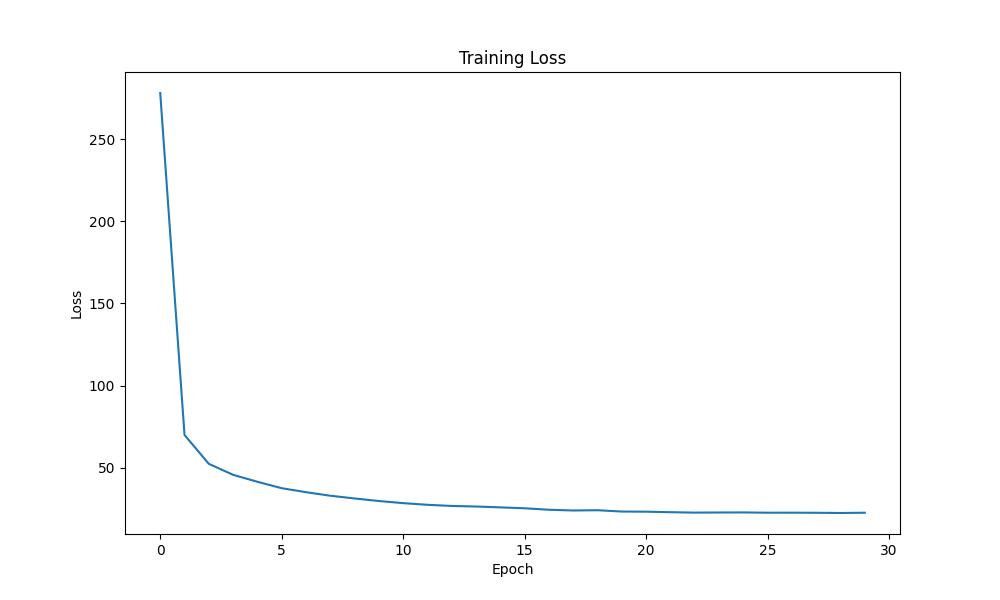

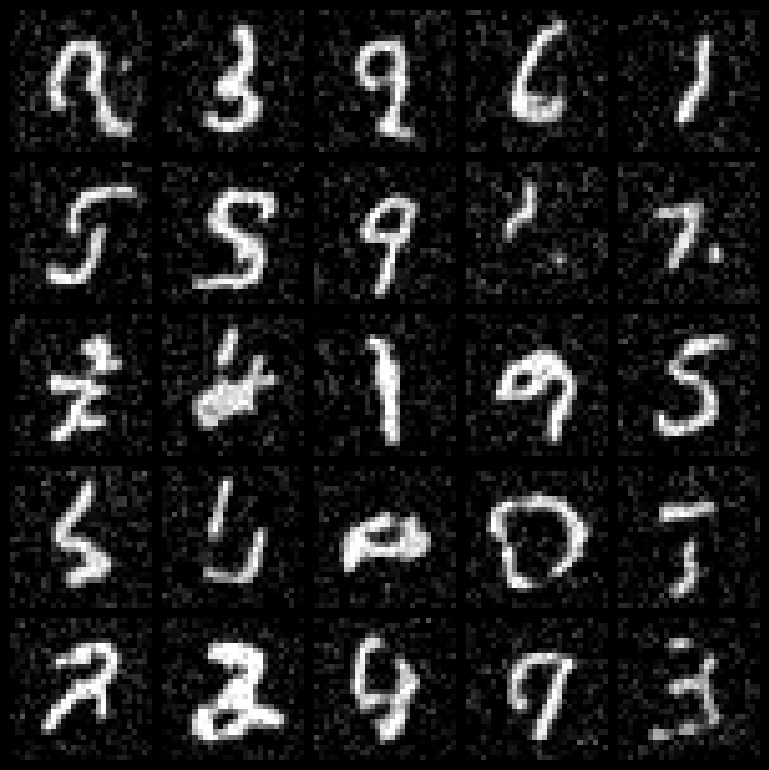